# Оценка социальной обеспеченности для городов федерального значения

- Гексы выступают в роли потенциальных проектов.
- Опорных НП нет, как в случае с `TownsNet`.
- Есть только параметры самих гексов.

In [3]:
!pip install "blocksnet==0.1.0" -q

In [5]:
from blocksnet import City

city = City.from_pickle('model_010.pickle')

## Разведка

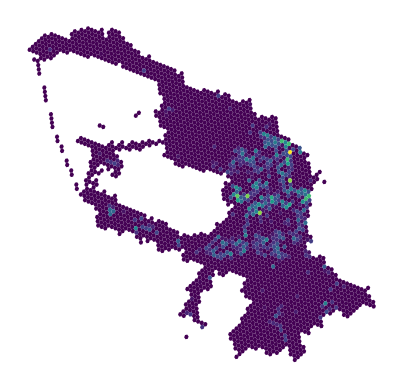

In [10]:
city.get_blocks_gdf().plot('capacity_school').set_axis_off()

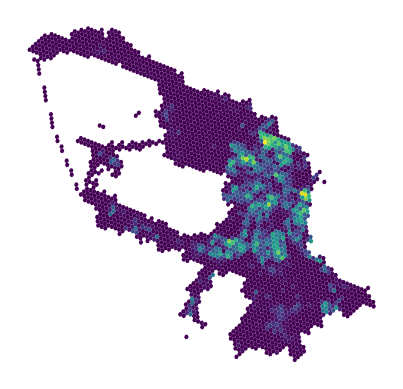

In [11]:
city.get_blocks_gdf().plot('population').set_axis_off()

## А. Оценка социалки через обеспеченность

- Считаем обеспеченность гексами по каждому загруженному типу сервисов.
- Считаем среднее.
- Нормализуем к `[0,5]` и округляем.

Минусы:
- Может долго считаться.
- Не определена для гексов без населения.

In [36]:
from blocksnet import Provision
from tqdm import tqdm

prov = Provision(city_model=city, verbose=False, max_depth=1)

provs_gdfs = {}
for service_type in tqdm(city.loaded_service_types):
    prov_gdf = prov.calculate(service_type)
    provs_gdfs[service_type] = prov_gdf

100%|██████████| 2/2 [00:14<00:00,  7.05s/it]


In [45]:
import numpy as np

prov_gdf = city.get_blocks_gdf(simplify=True)[['geometry']].copy()
for st,gdf in provs_gdfs.items():
    prov_gdf[f'provision_{st.name}'] = gdf['provision']

prov_gdf['provision'] = prov_gdf.drop(columns=['geometry']).mean(axis=1)
prov_gdf['provision'] = (prov_gdf['provision'] * 5).apply(lambda p : p if np.isnan(p) else round(p))

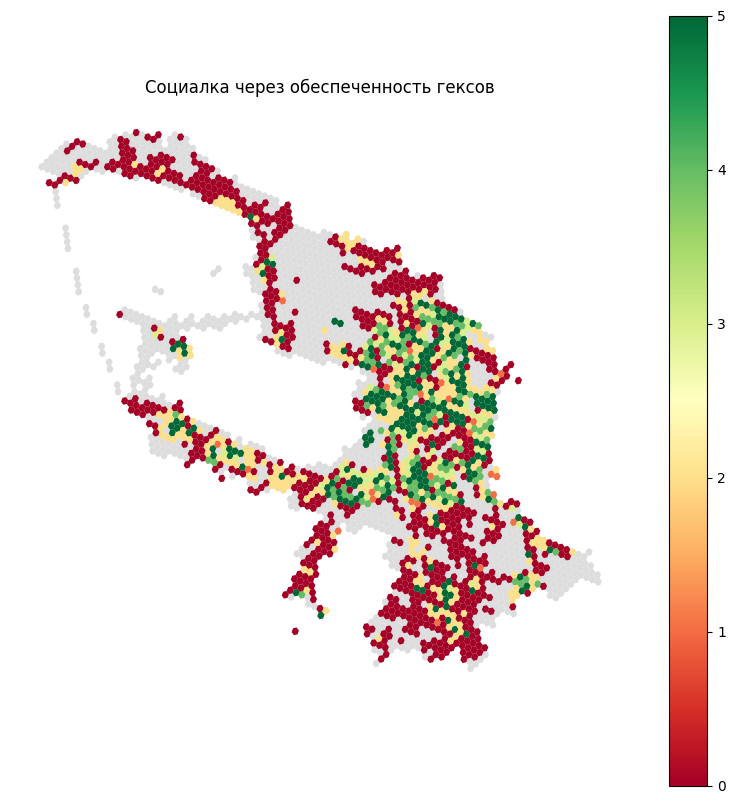

In [49]:
ax = prov_gdf.plot(color='#ddd', figsize=(10,10))
prov_gdf.plot('provision', ax=ax, cmap='RdYlGn', vmin=0, vmax=5, legend=True)
ax.set_title('Социалка через обеспеченность гексов')
ax.set_axis_off()

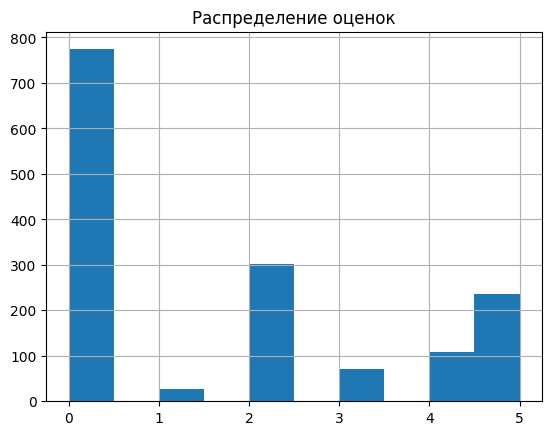

In [65]:
ax = prov_gdf.hist('provision', bins=10)[0][0]
ax = ax.set_title('Распределение оценок')

# Б. Оценка исходя из емкостей контекста

- Для каждого гекса строим контекст для каждого типа сервиса и считаем суммарные `capacity`.
- Нормируем к `[0,5]` и считаем среднее по каждому гексу, округляем.

Минусы:
- Сомнительная сценарность

In [87]:
import geopandas as gpd
import pandas as pd
from blocksnet import ServiceType
from sklearn.preprocessing import MinMaxScaler, StandardScaler

blocks_gdf = city.get_blocks_gdf()
acc_mx = city.accessibility_matrix

def _get_context_capacity(blocks_gdf : gpd.GeoDataFrame, acc_mx : pd.DataFrame, block_id : int, service_type : ServiceType):
    acc_s = acc_mx.loc[block_id]
    acc_s = acc_s[acc_s<=service_type.accessibility]
    capacities = blocks_gdf.loc[acc_s.index][f'capacity_{service_type.name}']
    return capacities.fillna(0).sum()

scaler = MinMaxScaler((0,5))
result_gdf = blocks_gdf[['geometry']].copy()

for service_type in tqdm(city.loaded_service_types):
    column = f'capacity_{service_type.name}'
    result_gdf[column] = blocks_gdf.apply(lambda s : _get_context_capacity(blocks_gdf, acc_mx, s.name, service_type), axis=1)
    result_gdf[column] = scaler.fit_transform(result_gdf[column].values.reshape(-1,1))

result_gdf['assessment'] = result_gdf.drop(columns=['geometry']).mean(axis=1).apply(round)

100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


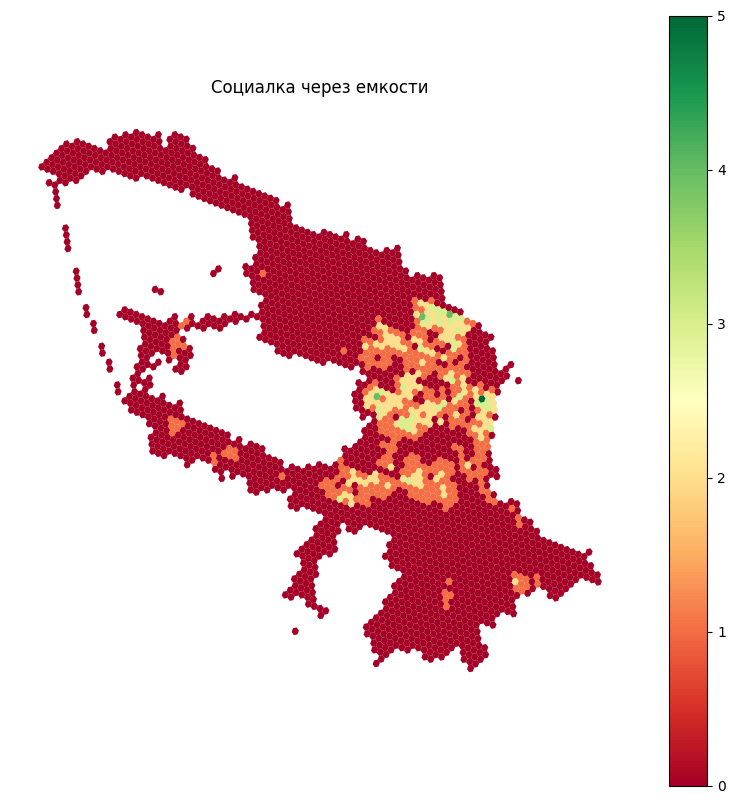

In [88]:
ax = result_gdf.plot(color='#ddd', figsize=(10,10))
result_gdf.plot('assessment', ax=ax, cmap='RdYlGn', vmin=0, vmax=5, legend=True)
ax.set_title('Социалка через емкости')
ax.set_axis_off()